In [1]:
# COMENZAMOS CON EL ENTRENAMIENTO DE LOS MODELOSfrom sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sys import path
sys.path.append('C:\\Users\\Laura\\Desktop\\Nueva carpeta\\Code\\util')

from funciones import graficos_conf_matrix

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix,recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

import pickle

In [5]:
# IMPORTAMOS EL CSV YA LIMPIO .
# LO VAMOS A DIVIDIR EN DOS, UNA PARTE PARA EL ENTRENAMIENTO-PREDICCIONES Y OTRA PARTE PARA EL TEST, COMO SI DE DATOS REALES SE TRATARAN


data_train = pd.read_csv('../Data/Processed/data_processed.csv', index_col=0)

data_train = data_train.iloc[:int(data_train.shape[0]*60/100), :]
data_test = data_train.iloc[int(data_train.shape[0]*60/100) : , :]

In [6]:
# DIVIDIMOS EN DATA_TRAIN EN TRAIN Y TEST


X_train, X_test, y_train, y_test = train_test_split(data_train.drop(columns=['Target','Anxiety','Stress'], axis=1), data_train.Target, random_state=0, test_size=0.20, shuffle=True)



RANDOM FOREST

In [63]:
# CREACION DE PIPELINE INICIAL.
# HACEMOS UN GRIDSEARCH CON CROSS VALIDATIION
# LO INSTANCIAMOS
model_rf = RandomForestClassifier() 


params = {'n_estimators' : range(100,500,100),
           'criterion': ['gini', 'entropy'],
           'max_depth':range(2,5),
           'max_leaf_nodes':range(2,10),
           'min_samples_split':range(50,300,50),
           'random_state' : [42],
            }


random_forest_gtc = GridSearchCV(model_rf, params, cv=5, scoring='f')
random_forest_gtc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 5),
                         'max_leaf_nodes': range(2, 10),
                         'min_samples_split': range(50, 300, 50),
                         'n_estimators': range(100, 500, 100),
                         'random_state': [42]},
             scoring='recall')

In [64]:
# SACAMOS LOS MEJORES PARÁMETROS PARA ENTRENAR EL MODELO

print (random_forest_gtc.best_params_)
print (random_forest_gtc.best_estimator_)

{'criterion': 'entropy', 'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_split': 50, 'n_estimators': 100, 'random_state': 42}
RandomForestClassifier(criterion='entropy', max_depth=2, max_leaf_nodes=2,
                       min_samples_split=50, random_state=42)


In [65]:
#CREAMOS UN NUEVO PIPELINE CON EL RESULTADO MEJOR RESULTADO DEL GRIDSEARCH
model_rf_V0 = random_forest_gtc.best_estimator_

In [3]:
model_rf_V0

RandomForestClassifier(criterion='entropy', max_depth=2, max_leaf_nodes=2,
                       min_samples_split=50, random_state=42)

In [7]:
# ENTRENAMOS EL MODELO Y SACAMOS LAS PREDICCIONES

model_rf_V0.fit(X_train,y_train)
y_predi = model_rf_V0.predict(X_test)

In [68]:
# PASAMOS LAS METRICAS A UN DATAFRAM

df_scores = pd.read_csv('../Model/scores_models_Recall.csv', index_col=0)
df_scores['rf_train'] =[recall_score(y_test,y_predi), roc_auc_score(y_test,y_predi),  accuracy_score(y_test, y_predi), f1_score(y_test, y_predi)]


df_scores

,log_re_train,log_re_test,rf_train
Recall,0.892715,0.896218,1.000000
Auc,0.841965,0.847397,0.500000
Accuracy,0.855437,0.858894,0.632726
F1_score,0.886550,0.886968,0.775055


In [8]:
# GUARDAMOS LA CONFUSION MATRIX PARA DESPUES GRAFICARLA
c_matrix_train = confusion_matrix(y_test, y_predi)

In [70]:
# GUARDAMOS EL MODELO

with open('../Model/model_rf_V0', 'wb') as archivo_salida:
    pickle.dump(model_rf_V0, archivo_salida)

In [9]:
# PROBAMOS EL MODELO CON LOS DATOS RESERVADOS PARA VER COMO GENERALIZA

X = data_test.drop(columns=['Target','Anxiety','Stress'], axis=1)
y= data_test.Target

with open('../Model/model_rf_V0', 'rb') as archivo_entrada:
    loaded_model = pickle.load(archivo_entrada)

In [10]:
loaded_model

RandomForestClassifier(criterion='entropy', max_depth=2, max_leaf_nodes=2,
                       min_samples_split=50, random_state=42)

In [12]:
# PASAMOS LAS METRICAS A UN DATAFRAM
df_scores['rf_test'] =[recall_score(y,loaded_model.predict(X)), roc_auc_score(y,loaded_model.predict(X)), accuracy_score(y, loaded_model.predict(X)), f1_score(y, loaded_model.predict(X))]
df_scores.to_csv('../Model/scores_models_Recall.csv')
df_scores

,log_re_data_train,log_re_test,knn_data_train,knn_data_test,xgb_data_train,xgb_data_test,rf_train,rf_test
Recall,0.892715,0.896218,0.868543,0.866881,0.000000,0.000000,1.000000,1.000000
Auc,0.841965,0.847397,0.850986,0.860818,0.500000,0.500000,0.500000,0.500000
Accuracy,0.855437,0.858894,0.855646,0.862246,0.367274,0.382254,0.632726,0.617746
F1_score,0.886550,0.886968,0.883909,0.886039,0.000000,0.000000,0.775055,0.763712


In [11]:
# GUARDAMOS LA CONFUSION MATRIX PARA DESPUES GRAFICARLA
c_matrix_test = confusion_matrix(y,loaded_model.predict(X))

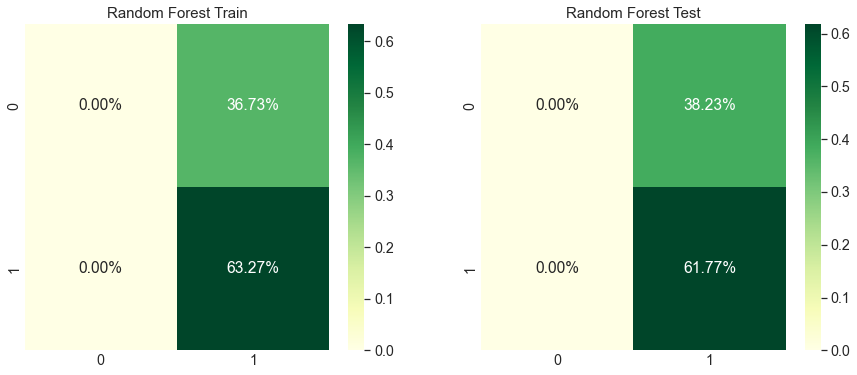

In [13]:
graf_rf_R_matriz = plt.figure(figsize=(15,6))


plt.style.use('seaborn-whitegrid')
plt.subplot(1,2,1)
sns.set(font_scale = 1.3)
graficos_conf_matrix(c_matrix_train,'Random Forest Train')

plt.style.use('seaborn-whitegrid')
plt.subplot(1,2,2)
sns.set(font_scale = 1.3)
graficos_conf_matrix(c_matrix_test,'Random Forest Test')

graf_rf_R_matriz.savefig ('../util/Graficos/graf_rf_R_matriz.png')